In [1]:
import matplotlib.pyplot as plt
import numpy as np
import stim 
import pymatching as pm
from qecsim.graphtools import mwpm
import networkx as nx
import sys
import torch
sys.path.append("../")
from src.simulations import SurfaceCodeSim

##### Code settings

In [2]:
reps = 3
code_sz = 3
p = 1e-3
n_shots = 1000

sim = SurfaceCodeSim(reps, code_sz, p, n_shots)
syndromes, flips, _ = sim.generate_syndromes()
detector_dict = sim.detector_indx
detector_dict
sim.get_circuit()

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19
    X_ERROR(0.001) 1 3 5 8 10 12 15 17 19
    R 2 9 11 13 14 16 18 25
    X_ERROR(0.001) 2 9 11 13 14 16 18 25
    TICK
    DEPOLARIZE1(0.001) 1 3 5 8 10 12 15 17 19
    H 2 11 16 25
    DEPOLARIZE1(0.001) 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    DEPOLARIZE2(0.001) 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    DEPOLARIZE2(0.001) 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    DEPOLARIZE2(0.001) 16 10 11 5 25 19 8 9 17

##### How to divide X- and Z-nodes

In [3]:
x = torch.tensor([
    [0, 1, 2, 8, 2, 3, 1, 5],
    [0, 9, 6, 2, 4, 1, 9, 3]
    ])
y = torch.tensor([2, 4, 1, 5, 8])

z = torch.isin(x, y)
z = z.sum(axis=0)
z


tensor([0, 1, 1, 2, 2, 1, 1, 1])

##### PyMatching

In [4]:
# test a complete graph
n = 10
g = nx.complete_graph(n)
g.nodes[0]["is_boundary"] = True
g.nodes[1]["is_boundary"] = True
matching = pm.Matching.from_networkx(g)

s = [True, True, False, True, False] * 2
matching.decode_to_edges_array(s)    
# nx.draw(g)

array([[5, 8],
       [3, 6]], dtype=int64)

##### Try out MWPM in QECSIM

In [5]:
# our edges will be of the form:
edges = np.array([[0, 1, 2, 3, 1, 2, 3, 4, 5, 1], [1, 0, 1, 2, 3, 0, 1, 1, 1, 2]])
n = 6
edges = np.row_stack(np.triu_indices(n, k=1))

weights = np.array([0, 2, 4, 12, 4, -21, -7, 6, 2, 2, 1, 4, 5, 124, 512, 5])
classes = np.array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1])

edges_w_weights = {tuple(sorted(x)): w for x, w in zip(edges.T, weights)}
edges_w_classes = {tuple(sorted(x)): c for x, c in zip(edges.T, classes)}
matched_edges = mwpm(edges_w_weights)

classes = np.array([edges_w_classes[edge] for edge in matched_edges])

matched_edges.add((2, 0))
x = [tuple(sorted((x[0], x[1]))) for x in matched_edges]
print(edges)




[[0 0 0 0 0 1 1 1 1 2 2 2 3 3 4]
 [1 2 3 4 5 2 3 4 5 3 4 5 4 5 5]]


In [88]:
x = [1, 2, 3, 4]
x[2:]

[3, 4]

##### Want to count how many edges pass the upper boundary

Distance: 2.00, class: False
Distance: 2.24, class: False
Distance: 6.71, class: True
Distance: 4.12, class: False


(-1.0, 11.0)

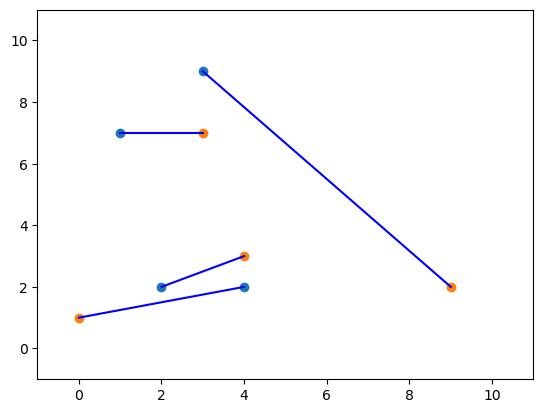

In [18]:
def cylinder_distance(x, y, width, wrap_axis=1, manhattan=False):
    # x, y have coordinates (x, y, t)
    
    ds = np.abs(x - y)
    eq_class = ds[:, wrap_axis] > 0.5 * width
    ds[eq_class, wrap_axis] = width - ds[eq_class, wrap_axis]
    
    if not manhattan:
        return np.sqrt((ds ** 2).sum(axis=1)), eq_class
    else:
        return ds.sum(axis=1), eq_class
    
p1s = np.array([
    [1, 2, 3, 4],
    [7, 2, 9, 2]
])

p2s = np.array([
    [3, 4, 9, 0],
    [7, 3, 2, 1]
])

distances, eq_class = cylinder_distance(p1s.T, p2s.T, 10, manhattan=False)

fig, ax = plt.subplots()
ax.scatter(p1s[0, :], p1s[1, :])
ax.scatter(p2s[0, :], p2s[1, :])
for p1, p2, dist, eq in zip(p1s.T, p2s.T, distances, eq_class):
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], "b")
    print(f"Distance: {dist:.2f}, class: {eq}")
    
ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])